# A prototype Constraint class

To begin a `Constraints` prototype, I started with what seemed natural to me. I realize that this already departs from what was written in the API, but let's use it as a starting point for discussion.

Instead of creating an individual class for each type of constraint, it seemed more natural to me to have one `Constraints` object with a method for each constraint that you apply. This way:

* we can naturally store properties intrinsic to each stack of constraint computations on the object, like the target, observer, and time-range
* we can cache useful quantities in the object and reuse them when they've been pre-computed
* we can identify when the constraints render an object unobservable and "short-circuit" the application of additional constraints before they've begun
* results from each individual constraint can be cached and recombined in different permutations later

In [75]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from astroplan import Observer, FixedTarget
from astropy.coordinates import get_sun, SkyCoord
from astropy.time import Time
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

class Constraints(object):
    """
    Container for:
     * which constraints are met
     * a target's/sun position, cached
    """
    def __init__(self, time_range, target, observer, time_resolution=0.5*u.hour):
        self.are_met = None
        self.target = target
        self.time_range = time_range
        step_days = time_resolution.to(u.day).value
        self.times = Time(np.arange(self.time_range[0].jd,
                                    self.time_range[1].jd+step_days, step_days),
                          format='jd')
        self.observer = observer
        self.target_altaz = None
        self.sun_altaz = None
        self.moon_altaz = None
        self.altaz_frame = self.observer.altaz(self.times)
        # "short-circuit" for targets once they're determined unobservable
        self.skip_future_constraints = False
        self.constraints_applied = dict()

    def target_above_horizon(self, horizon=0*u.deg):
        if not self.skip_future_constraints:
            if self.target_altaz is None:
                self.target_altaz = self.observer.altaz(self.times, self.target)

            condition = self.target_altaz.alt > horizon
            if self.are_met is None:
                self.are_met = condition
            else:
                self.are_met *= condition

            self.constraints_applied['target_above_horizon'] = condition
                
            if not np.any(self.are_met):
                self.skip_future_constraints = True

    def sun_below_horizon(self, horizon=0*u.deg):
        if not self.skip_future_constraints:
            if self.sun_altaz is None:
                self.sun_altaz = get_sun(self.times).transform_to(self.altaz_frame)

            condition = self.sun_altaz.alt < horizon
            if self.are_met is None:
                self.are_met = condition
            else:
                self.are_met *= condition

            self.constraints_applied['sun_below_horizon'] = condition
                
            if not np.any(self.are_met):
                self.skip_future_constraints = True

    def altitude_constraint(self, min=None, max=None):
        if not self.skip_future_constraints:
            if self.target_altaz is None:
                self.target_altaz = self.observer.altaz(self.times, self.target)

            if max is None:
                max = 90*u.deg
            if min is None:
                min = -90*u.deg

            condition = (min < self.target_altaz.alt) * (self.target_altaz.alt < max)

            if self.are_met is None:
                self.are_met = condition
            else:
                self.are_met *= condition

            self.constraints_applied['altitude_constraint'] = condition
                
            if not np.any(self.are_met):
                self.skip_future_constraints = True

    def airmass_constraint(self, max=None, min=None):
        if not self.skip_future_constraints:
            if self.target_altaz is None:
                self.target_altaz = self.observer.altaz(self.times, self.target)

            if max is None:
                max = 100
            if min is None:
                min = 1

            condition = (min < self.target_altaz.secz) * (self.target_altaz.secz < max)

            if self.are_met is None:
                self.are_met = condition
            else:
                self.are_met *= condition
            
            self.constraints_applied['airmass_constraint'] = condition
                
            if not np.any(self.are_met):
                self.skip_future_constraints = True

## Set up observer, target; define constraints

In [86]:
# Define observer, target, time range for observations
apo = Observer.at_site("Apache Point Observatory")
target = FixedTarget.from_name('Vega')
start_time = Time.now()
end_time = start_time + 3*u.day

# Define constraints
constraints = Constraints([start_time, end_time], target, apo,
                          time_resolution=0.5*u.hour)
constraints.target_above_horizon(horizon=20*u.deg)
constraints.sun_below_horizon(horizon=-6*u.deg)
constraints.airmass_constraint(max=2)

## Visual sanity check

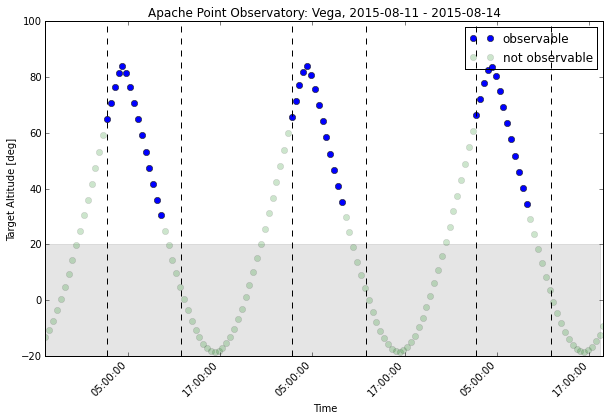

In [87]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,6))
# Where "observable", i.e. constraints met
ax.plot_date(constraints.times.plot_date[constraints.are_met], 
             constraints.target_altaz.alt[constraints.are_met], 
             'o', label='observable')
# Where not "observable", i.e. constraints not met
ax.plot_date(constraints.times.plot_date[~constraints.are_met], 
             constraints.target_altaz.alt[~constraints.are_met], 
             label='not observable', alpha=0.2)

# Draw lines at civil twilight (our defined solar horizon limits)
ref_lines = [apo.evening_civil(start_time, which='next'),
             apo.evening_civil(start_time+1*u.day, which='next'),
             apo.evening_civil(start_time+2*u.day, which='next'),
             apo.morning_civil(start_time, which='next'),
             apo.morning_civil(start_time+1*u.day, which='next'),
             apo.morning_civil(start_time+2*u.day, which='next')]
[ax.axvline(ref_line.plot_date, color='k', ls='--') for ref_line in ref_lines]

# Fill below minimum target altitude
ax.fill_between([start_time.plot_date, end_time.plot_date], 
                -20, 20, color='k', alpha=0.1)
[l.set(rotation=45, ha='right') for l in ax.get_xticklabels()]
title_fmt = "%Y-%m-%d"
title_string = '{}: {}, {} - {}'.format(apo.name, target.name,
                                        start_time.datetime.strftime(title_fmt), 
                                        end_time.datetime.strftime(title_fmt))
ax.set(xlabel='Time', ylabel="Target Altitude [deg]",
       title=title_string)
ax.legend()
plt.show()

#### Check out results from individual constraints:

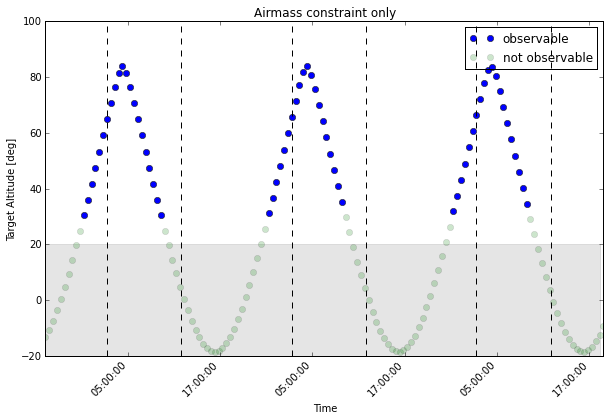

In [88]:
individual_constraint = constraints.constraints_applied['airmass_constraint']

fig, ax = plt.subplots(figsize=(10,6))
# Where "observable", i.e. constraints met
ax.plot_date(constraints.times.plot_date[individual_constraint], 
             constraints.target_altaz.alt[individual_constraint], 
             'o', label='observable')
# Where not "observable", i.e. constraints not met
ax.plot_date(constraints.times.plot_date[~individual_constraint], 
             constraints.target_altaz.alt[~individual_constraint], 
             label='not observable', alpha=0.2)

# Draw lines at civil twilight (our defined solar horizon limits)
[ax.axvline(ref_line.plot_date, color='k', ls='--') for ref_line in ref_lines]

# Fill below minimum target altitude
ax.fill_between([start_time.plot_date, end_time.plot_date], 
                -20, 20, color='k', alpha=0.1)
[l.set(rotation=45, ha='right') for l in ax.get_xticklabels()]
title_fmt = "%Y-%m-%d"
title_string = "Airmass constraint only"
ax.set(xlabel='Time', ylabel="Target Altitude [deg]",
       title=title_string)
ax.legend()
plt.show()